In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pickle

from matplotlib.font_manager import FontProperties
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from pathlib import Path
from typing import Literal

from datautilities import meshmethods as mm
from datautilities import MeshIO as io

In [2]:
lr_res = "LR8_raw_6cpu"
hr_res = "HR_6cpu"
train_years = [1959, 1960, 1961, 1962, 1963]
test_years = 1964

regions = [1, 2, 3]
region_pattern = "Region{}LR4"

root_dirs = [Path("../Data") / region_pattern.format(nreg) for nreg in regions]

In [3]:
class PreProcessing:
    def __init__(self):
        self.mean = None
        self.std = None

        self.pca = None

    @staticmethod
    def delete_nans(X: np.ndarray):
        """X has to be of shape (nsamples, nfeatures)"""
        nan_idx = np.nonzero(np.isnan(X).all(axis=0))[0]
        return np.delete(X, nan_idx, axis=1)

    def znormalize(self, X: np.ndarray):
        if self.mean is None or self.std is None:
            raise ValueError(
                ("Either 'self.mean or self.std is 'None'. Precompute them "
                 "by calling znormalize_fit first.")
            )
        return (X - self.mean) / self.std

    def znormalize_fit(self, X: np.ndarray):
        """Precompute mean and std of data set for later normalization"""
        self.mean = np.nanmean(X, axis=0)
        self.std = np.nanstd(X, axis=0)

    def pca_transform(self, X: np.ndarray):
        """Wrapper around sklearn's 'PCA.transform()' method"""
        if self.pca is None:
            raise ValueError(
                "No PCA instance found. Call pca_fit first to transform data."
            )
        return self.pca.transform(X)

    def pca_fit(self, X: np.ndarray, **kwargs):
        """Fit PCA instance. Kwargs are passed to pca initialization."""
        pca = PCA(**kwargs)
        self.pca = pca.fit(X)

    @staticmethod
    def polynomial_transform(X: np.ndarray, degree: int = 2):
        return PolynomialFeatures(degree=degree).fit_transform(X)

def preprocessing_pipeline(
    pp: PreProcessing,
    X: np.ndarray,
    y: np.ndarray,
    nreg: int,
    mode: Literal["train", "test"] = "train",
    delete_nans: bool = True,
    polynomials: int = 2,
    znormalize: bool = True,
    pca_transform: bool = True,
    **kwargs
) -> tuple[PreProcessing, np.ndarray, np.ndarray]:
    """Pipeline that processes input and target data. The preprocessing
    class stores the data that is necessary to perform later transforms.

    Parameters
    ----------
    pp : PreProcessing
        PreProcessing instance that is used to store or retrieve parameters
        to correctly preprocess the data
    X : np.ndarray
        Input data to be preprocessed. Assumed shape: (nsamples, nfeatures)
    y : np.ndarray
        Target data to be preprocessed. Assumed shape: (nsamples, nfeatures)
    nreg : int
        Number of the region. Used to determine the root directory.
    mode : Literal['train', 'test'], optional
        If data should be fitted or just transformed, by default "train"
    delete_nans : bool
        If delete_nans should be called. Otherwise nan_to_num is used
        to treat nan data. By default True
    polynomials : int
        If 0, no polynomials are added. If > 0 then this is used as the
        degree of the polynomials. By default 0
    znormalize : bool
        If input should be znormalized, by default True
    pca_transform : bool
        If input should be pca-transformed, by default True
    **kwargs :
        Keyword arguments are passed to pca_fit

    Returns
    -------
    tuple[PreProcessing, np.ndarray, np.ndarray]
        Returns 'PreProcessing' instance with the stored parameters and the
        transformed inputs and targets
    """
    if delete_nans:
        X = pp.delete_nans(X)
        # y = pp.delete_nans(y)

        # Workaround for differing nan data in different variables
        y = np.delete(y, np.load(f"../Data/Region{nreg}LR4/HR_6cpu/drop_index.npy"),
                      axis=1)
    else:
        X = np.nan_to_num(X)
        y = np.nan_to_num(y)

    if polynomials:
        X = pp.polynomial_transform(X, degree=polynomials)

    if mode == "train":
        pp.znormalize_fit(X)
        pp.pca_fit(X, **kwargs)

    if znormalize:
        X = pp.znormalize(X)
    if pca_transform:
        X = pp.pca_transform(X)

    return pp, X, y


In [4]:
diffs = []
y_tests = []
for idx, root_dir in enumerate(root_dirs):
    pp = PreProcessing()

    X = mm.load_data(res=lr_res, years=train_years, root_dir=root_dir)

    y = mm.load_data(res=hr_res, years=train_years, root_dir=root_dir)

    kwargs = dict(
        delete_nans=True,
        polynomials=2,
        pca_transform=False,
        znormalize=False,
        whiten=False,
    )

    pp, X, y = preprocessing_pipeline(pp, X, y, idx+1, **kwargs)

    reg = Ridge(0.005, fit_intercept=False)
    # reg = LinearRegression(fit_intercept=False)
    reg = reg.fit(X, y)

    X_test = mm.load_data(res=lr_res, years=test_years, root_dir=root_dir)
    y_test = mm.load_data(res=hr_res, years=test_years, root_dir=root_dir)

    pp, X_test, y_test = preprocessing_pipeline(
            pp, X_test, y_test, idx+1, mode="test", **kwargs
        )

    diffs.append(np.abs(reg.predict(X_test) - y_test)/y_test)
    y_tests.append(y_test)

/home/jannik/Documents/PhD/Super_Resolution_General/SROnUnstructuredGrids/datautilities/datautilities/meshmethods.py:106: RuntimeWarning: invalid value encountered in cast
  data[idx] = np.load(fpath).squeeze()
/home/jannik/anaconda3/envs/ugrid/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/jannik/Documents/PhD/Super_Resolution_General/SROnUnstructuredGrids/datautilities/datautilities/meshmethods.py:106: RuntimeWarning: invalid value encountered in cast
  data[idx] = np.load(fpath).squeeze()
/home/jannik/Documents/PhD/Super_Resolution_General/SROnUnstructuredGrids/datautilities/datautilities/meshmethods.py:106: RuntimeWarning: invalid value encountered in cast
  data[idx] = np.load(fpath).squeeze()
/home/jannik/anaconda3/envs/ugrid/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/jannik/Documents/PhD/Super_Resolution_Gener

In [9]:
# Compute mae, rmse, and max error for regression and save them
out_path = Path("box-data") / "stats_norm_polyreg.npy"

if out_path.exists():
    stats_polyreg = np.load(out_path)
else:
    maes = np.empty((len(diffs)))
    rmses = np.empty((len(diffs)))
    max_errors = np.empty((len(diffs)))

    for idx, diff in enumerate(diffs):
        # Convert it to cm
        diff = 100*diff
        maes[idx] = np.nanmean(diff)
        rmses[idx] = np.sqrt(np.nanmean(diff**2))
        max_errors[idx] = np.nanmax(diff)
    
    stats_polyreg = np.vstack([maes, rmses, max_errors]).T
    np.save(out_path, stats_polyreg)


In [23]:
stats_graphnet = np.load(Path("box-data") / "stats_norm_graphnet.npy")

In [11]:
out_path = Path("box-data") / "box_list_norm_polyreg.pkl"

if out_path.exists():
    general_box_list = pickle.load(out_path.open("rb"))
else:
    general_box_list = []
    for diff in diffs:
        diff = 100*diff  # Convert to cm
        box = {}
        box["med"] = np.nanmedian(diff)
        box["q1"] = np.nanpercentile(diff, 25)
        box["q3"] = np.nanpercentile(diff, 75)
        box["whislo"] = np.nanpercentile(diff, 5)
        box["whishi"] = np.nanpercentile(diff, 95)
        box["mean"] = np.nanmean(diff)

        general_box_list.append(box)

    pickle.dump(general_box_list, out_path.open("wb"))

In [12]:
edges = np.arange(0, 4.6, 0.5)

labels = []
for i in range(len(edges)-1):
    labels.append(f"{edges[i]}m\n-{edges[i+1]}m")

labels[0] = "<0.5m"
labels[-1] = ">4m"

In [ ]:
diffs_flat = [diff.flatten()*100 for diff in diffs]

In [13]:
offshore_pnts = [139, 358, 33]
errors_list = []
for idx, diff in enumerate(diffs):
    errors = []
    # Convert to %
    diff = 100*diff

    for i in range(len(edges) - 1):
        range_mask = (edges[i] <= y_tests[idx][:, offshore_pnts[idx]]) & (y_tests[idx][:, offshore_pnts[idx]] < edges[i+1])
        errors.append(diff[range_mask].flatten())

    errors_list.append(errors)


In [17]:
out_path = Path("box-data") / "box_list_of_lists_norm_off_polyreg.pkl"

if out_path.exists():
    box_list_of_lists = pickle.load(out_path.open("rb"))
else:
    # Compute boxplot stats for each separate wave height range
    box_list_of_lists = []
    for error_list in errors_list:
        box_list = []
        for errors in error_list:
            box = {}
            box["med"] = np.nanmedian(errors)
            box["q1"] = np.nanpercentile(errors, 25)
            box["q3"] = np.nanpercentile(errors, 75)
            box["whislo"] = np.nanpercentile(errors, 5)
            box["whishi"] = np.nanpercentile(errors, 95)
            box["mean"] = np.nanmean(errors)

            box_list.append(box)

        box_list_of_lists.append(box_list)

    pickle.dump(box_list_of_lists, out_path.open("wb"))

In [24]:
# Load pre-computed graphnet boxplot stats
general_box_list_graphnet = pickle.load((Path("box-data") / "box_list_norm_graphnet.pkl").open("rb"))
box_list_of_lists_graphnet = pickle.load((Path("box-data") / "box_list_of_lists_norm_off_graphnet.pkl").open("rb"))

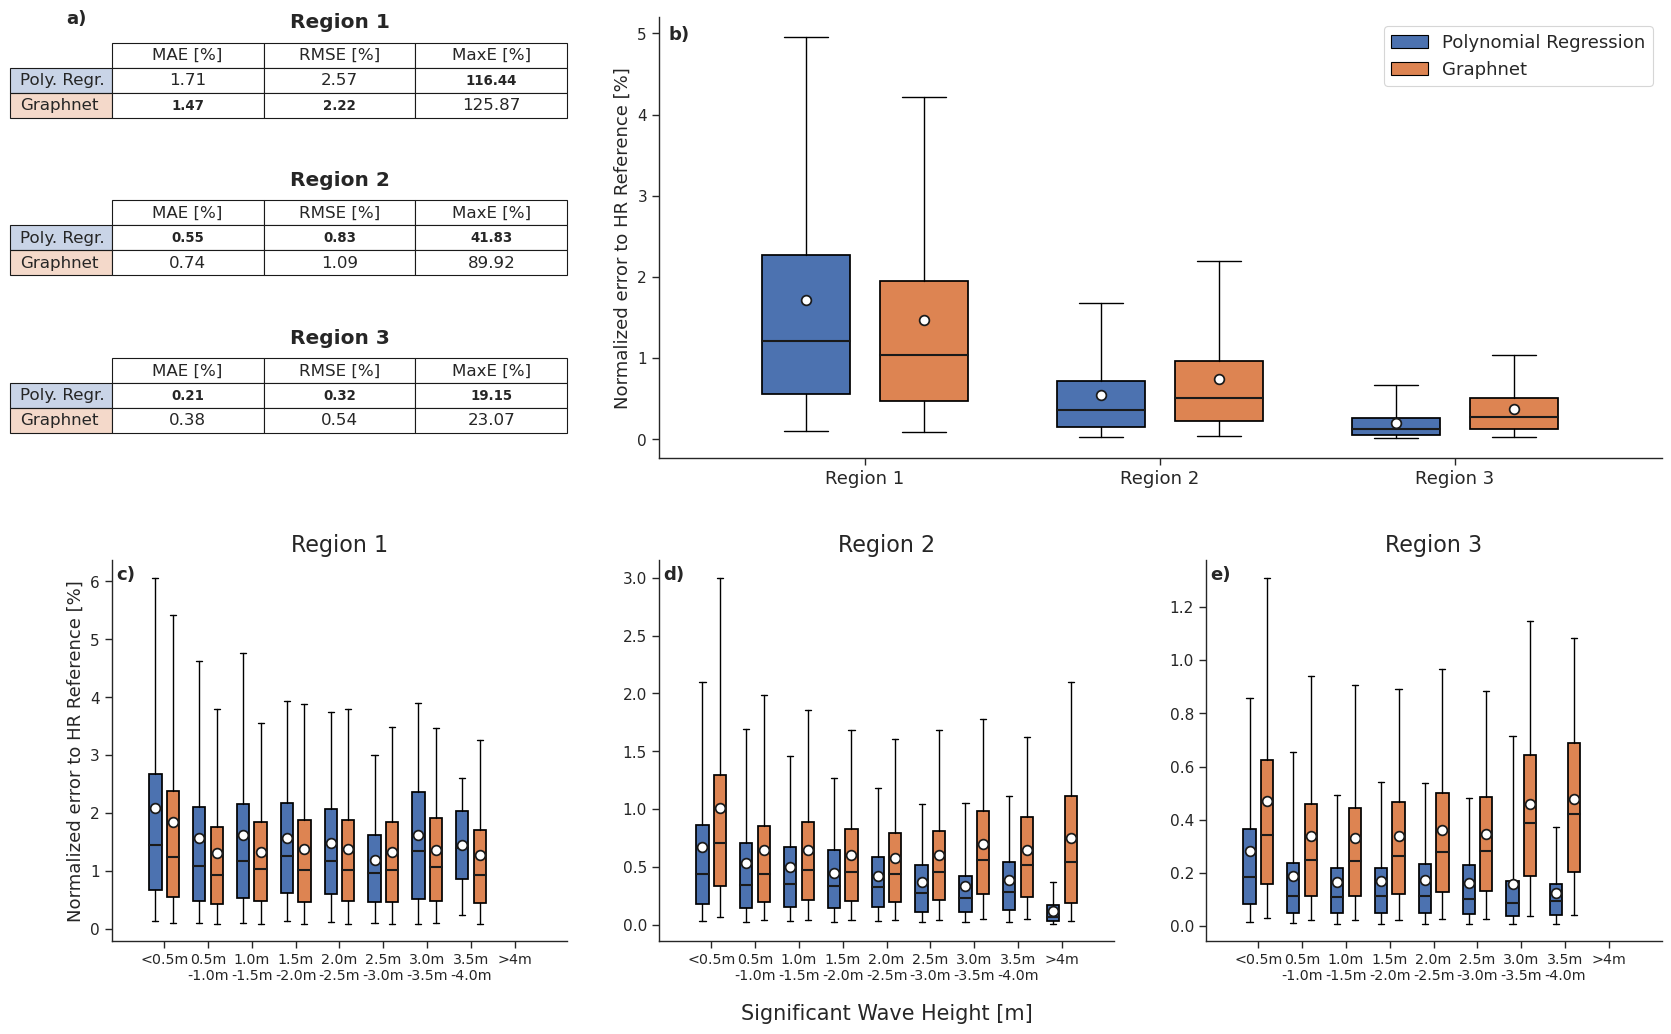

In [25]:
mosaic = [["table1", "all", "all"],
          ["table2", "all", "all"],
          ["table3", "all", "all"],
          [".", ".", "."],
          ["reg1", "reg2", "reg3"]]

height_ratios = [0.33, 0.33, 0.33, 0.1, 1]

fig, axs = plt.subplot_mosaic(mosaic=mosaic, figsize=(20, 12),
                              height_ratios=height_ratios)

sns.set_theme(context="paper", style="ticks")
sns.despine()

plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 13
plt.rcParams["xtick.labelsize"] = 10.25
plt.rcParams["ytick.labelsize"] = 11

# ------------------- Table 1 -----------------------
# Get some transparent background colors
colors = sns.color_palette(n_colors=2)
colors = [list(colors[0]) + [0.3], list(colors[1]) + [0.3]]

for idx in range(3):
    ax = axs[f"table{idx+1}"]

    # Remove axes
    ax.axis('off')

    data = {
        ('MAE [%]'): [stats_polyreg[idx, 0], stats_graphnet[idx, 0]],
        ('RMSE [%]'): [stats_polyreg[idx, 1], stats_graphnet[idx, 1]],
        ('MaxE [%]'): [stats_polyreg[idx, 2], stats_graphnet[idx, 2]],
       #  ('MAE [%]'): [stats_polyreg[idx, 0], stats_polyreg[idx, 0]],
       #  ('RMSE [%]'): [stats_polyreg[idx, 1], stats_polyreg[idx, 1]],
       #  ('MaxE [%]'): [stats_polyreg[idx, 2], stats_polyreg[idx, 2]],
    }

    # Create a DataFrame with MultiIndex
    df = pd.DataFrame(data, index=['Poly. Regr.', 'Graphnet'])
    # Get the indices to highlight as bold
    min_idx = df.values.argmin(axis=0) + 1  # +1 because of the header
    df = df.applymap(lambda x: f"{x:.2f}")

    # Create a table
    table = ax.table(cellText=df.values,
                    colLabels=df.columns,
                    rowLabels=df.index,
                    rowColours=colors,
                    cellLoc='center', 
                    loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)

    # Highlight in bold the minimum value
    for (row, col) in zip(min_idx, [0, 1, 2]):
        cell = table[row, col]
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

    ax.set_title(f"Region {idx+1}", y=0.85,
                 fontdict={"fontsize": 14.5, "fontweight": "bold"})

# ------------------- All regions -------------------
ax = axs["all"]

positions1 = [0.80, 1.80, 2.80]
positions2 = [1.2, 2.2, 3.2]
widths = 0.3
medianprops = dict(linestyle="-", linewidth=1.5, color="k")
meanprops = dict(marker="o", markerfacecolor="white", markeredgecolor="k",
                 markersize=7, markeredgewidth=1.25)

lbox1 = mpatches.Patch(facecolor="C0", edgecolor="black", label="Polynomial Regression")
lbox2 = mpatches.Patch(facecolor="C1", edgecolor="black", label="Graphnet")

ax.bxp(general_box_list, showmeans=True, showfliers=False, positions=positions1,
       widths=widths, patch_artist=True, boxprops=dict(facecolor="C0", linewidth=1.25),
       medianprops=medianprops, meanprops=meanprops)
ax.bxp(general_box_list_graphnet, showmeans=True, showfliers=False, positions=positions2,
       widths=widths, patch_artist=True, boxprops=dict(facecolor="C1", linewidth=1.25),
       medianprops=medianprops, meanprops=meanprops)

ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["Region 1", "Region 2", "Region 3"], size=13)

ax.legend(handles=[lbox1, lbox2], loc="upper right", fontsize=13)

# ------------------- Regional Plots -------------------
positions1 = np.arange(0.15, 4.64, 0.5)
positions2 = np.arange(0.35, 4.84, 0.5)

widths = 0.14

medianprops = dict(linestyle="-", linewidth=1.5, color="k")
meanprops = dict(marker="o", markerfacecolor="white", markeredgecolor="k",
                 markersize=7, markeredgewidth=1.25)

for idx in range(3):
    ax = axs[f"reg{idx+1}"]
    
    box_list = box_list_of_lists[idx]
    box_list_graph = box_list_of_lists_graphnet[idx]

    ax.bxp(box_list, showmeans=True, showfliers=False, positions=positions1,
           widths=widths, patch_artist=True, boxprops=dict(facecolor="C0", linewidth=1.25),
           medianprops=medianprops, meanprops=meanprops)
    ax.bxp(box_list_graph, showmeans=True, showfliers=False, positions=positions2,
           widths=widths, patch_artist=True, boxprops=dict(facecolor="C1", linewidth=1.25),
           medianprops=medianprops, meanprops=meanprops)

    ax.set_xticks(np.arange(0.25, 4.74, 0.5))
    ax.set_xticklabels(labels)

    ax.set_title(f"Region {idx+1}")

axs["all"].set_ylabel("Normalized error to HR Reference [%]")
axs["reg1"].set_ylabel("Normalized error to HR Reference [%]")
axs["reg2"].set_xlabel("Significant Wave Height [m]", size=15, labelpad=15)

# Panel relative location
x = 0.01
y = 0.95
# Add panel labels
plt.rcParams["font.size"] = 13
axs["table1"].text(-0.1, y, "a)", transform=axs["table1"].transAxes, fontweight="bold")
axs["all"].text(x, y, "b)", transform=axs["all"].transAxes, fontweight="bold")
axs["reg1"].text(x, y, "c)", transform=axs["reg1"].transAxes, fontweight="bold")
axs["reg2"].text(x, y, "d)", transform=axs["reg2"].transAxes, fontweight="bold")
axs["reg3"].text(x, y, "e)", transform=axs["reg3"].transAxes, fontweight="bold")


out_path = Path("plots") / "boxplots" / "error-distribution-train5years-test-1964"
out_path.parent.mkdir(exist_ok=True, parents=True)
# plt.savefig(out_path, dpi=300, bbox_inches="tight")

plt.show()